##### Step 1: Load All Required Files

In [58]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from prophet import Prophet
import warnings
warnings.filterwarnings('ignore')

# Load all datasets
store = pd.read_csv('store.csv')
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')  

print("Store data shape:", store.shape)
print("Train data shape:", train.shape)
print("\nTrain data info:")
print(train.info())
print("\nFirst few rows:")
print(train.head())

Store data shape: (1115, 10)
Train data shape: (1017209, 9)

Train data info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1017209 entries, 0 to 1017208
Data columns (total 9 columns):
 #   Column         Non-Null Count    Dtype 
---  ------         --------------    ----- 
 0   Store          1017209 non-null  int64 
 1   DayOfWeek      1017209 non-null  int64 
 2   Date           1017209 non-null  object
 3   Sales          1017209 non-null  int64 
 4   Customers      1017209 non-null  int64 
 5   Open           1017209 non-null  int64 
 6   Promo          1017209 non-null  int64 
 7   StateHoliday   1017209 non-null  object
 8   SchoolHoliday  1017209 non-null  int64 
dtypes: int64(7), object(2)
memory usage: 69.8+ MB
None

First few rows:
   Store  DayOfWeek        Date  Sales  Customers  Open  Promo StateHoliday  \
0      1          5  2015-07-31   5263        555     1      1            0   
1      2          5  2015-07-31   6064        625     1      1            0   
2    

#### Step 2: Data Cleaning & Merging

In [59]:
# Convert Date column to datetime
train['Date'] = pd.to_datetime(train['Date'])

# Merge store information with sales data
df = train.merge(store, on='Store', how='left')

print("\nMerged data shape:", df.shape)
print(df.info())

# Check for missing values
print("\nMissing values:")
print(df.isnull().sum())


Merged data shape: (1017209, 18)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1017209 entries, 0 to 1017208
Data columns (total 18 columns):
 #   Column                     Non-Null Count    Dtype         
---  ------                     --------------    -----         
 0   Store                      1017209 non-null  int64         
 1   DayOfWeek                  1017209 non-null  int64         
 2   Date                       1017209 non-null  datetime64[ns]
 3   Sales                      1017209 non-null  int64         
 4   Customers                  1017209 non-null  int64         
 5   Open                       1017209 non-null  int64         
 6   Promo                      1017209 non-null  int64         
 7   StateHoliday               1017209 non-null  object        
 8   SchoolHoliday              1017209 non-null  int64         
 9   StoreType                  1017209 non-null  object        
 10  Assortment                 1017209 non-null  object        
 11  Com

#### Step 3: Handle Missing Values

In [60]:
# Fill missing CompetitionDistance with a large number (no competition nearby)
df['CompetitionDistance'].fillna(df['CompetitionDistance'].max() * 1.5, inplace=True)

# Fill missing competition opening dates
df['CompetitionOpenSinceMonth'].fillna(0, inplace=True)
df['CompetitionOpenSinceYear'].fillna(0, inplace=True)

# Fill Promo2 related missing values
df['Promo2SinceWeek'].fillna(0, inplace=True)
df['Promo2SinceYear'].fillna(0, inplace=True)
df['PromoInterval'].fillna('None', inplace=True)

# Remove days when store was closed or had zero sales
df_open = df[df['Open'] == 1].copy()
df_open = df_open[df_open['Sales'] > 0].copy()

print("\nData after cleaning:", df_open.shape)


Data after cleaning: (844338, 18)


##### Step 4: Feature Engineering for Rossmann Dataset

In [61]:
# Extract time-based features
df_open['Year'] = df_open['Date'].dt.year
df_open['Month'] = df_open['Date'].dt.month
df_open['Day'] = df_open['Date'].dt.day
df_open['WeekOfYear'] = df_open['Date'].dt.isocalendar().week
df_open['DayOfWeek'] = df_open['Date'].dt.dayofweek
df_open['Quarter'] = df_open['Date'].dt.quarter

# Calculate competition duration in months
df_open['CompetitionOpen'] = 12 * (df_open['Year'] - df_open['CompetitionOpenSinceYear']) + \
                              (df_open['Month'] - df_open['CompetitionOpenSinceMonth'])
df_open['CompetitionOpen'] = df_open['CompetitionOpen'].apply(lambda x: x if x > 0 else 0)

# Calculate Promo2 duration
df_open['Promo2Open'] = 12 * (df_open['Year'] - df_open['Promo2SinceYear']) + \
                        (df_open['WeekOfYear'] - df_open['Promo2SinceWeek']) / 4
df_open['Promo2Open'] = df_open['Promo2Open'].apply(lambda x: x if x > 0 else 0)

# Check if the month is in PromoInterval
def is_promo_month(row):
    if row['PromoInterval'] == 'None':
        return 0
    month_map = {1: 'Jan', 2: 'Feb', 3: 'Mar', 4: 'Apr', 5: 'May', 6: 'Jun',
                 7: 'Jul', 8: 'Aug', 9: 'Sept', 10: 'Oct', 11: 'Nov', 12: 'Dec'}
    month_abbr = month_map[row['Month']]
    return 1 if month_abbr in row['PromoInterval'] else 0

df_open['IsPromoMonth'] = df_open.apply(is_promo_month, axis=1)

print("\nFeature engineering complete!")
print(df_open[['Date', 'Sales', 'Year', 'Month', 'CompetitionOpen', 'IsPromoMonth']].head())


Feature engineering complete!
        Date  Sales  Year  Month  CompetitionOpen  IsPromoMonth
0 2015-07-31   5263  2015      7             82.0             0
1 2015-07-31   6064  2015      7             92.0             1
2 2015-07-31   8314  2015      7            103.0             1
3 2015-07-31  13995  2015      7             70.0             0
4 2015-07-31   4822  2015      7              3.0             0


##### Step 5: Exploratory Data Analysis

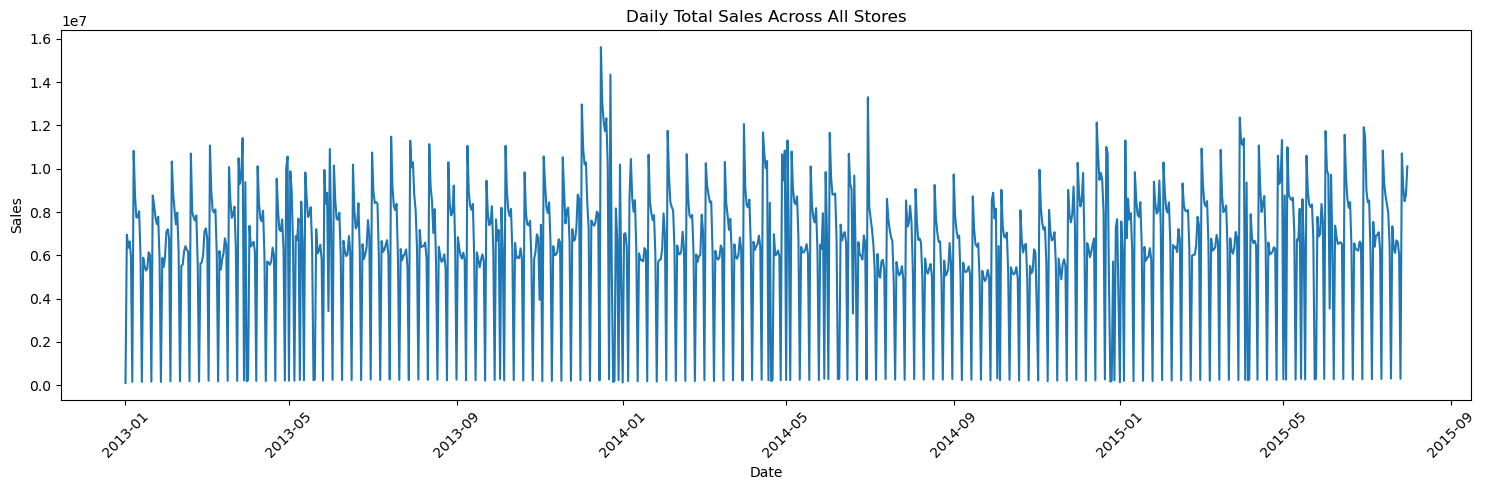

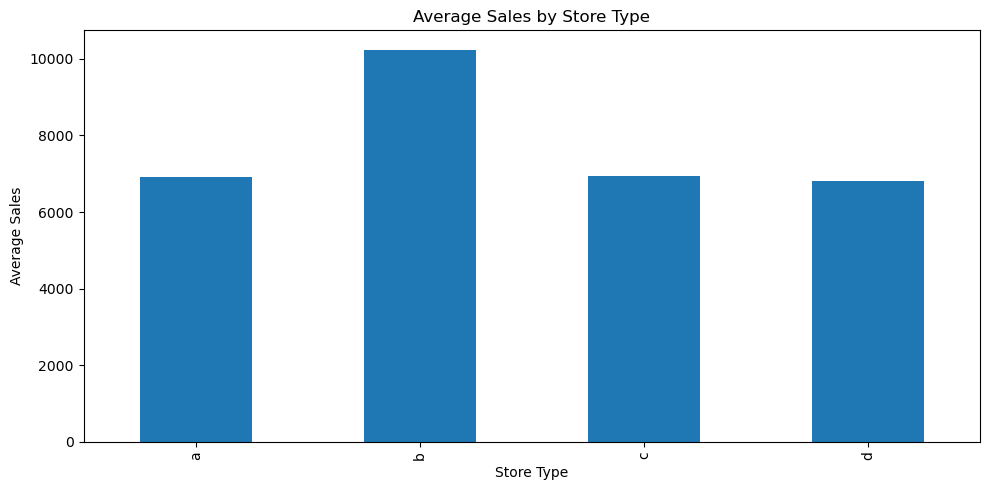

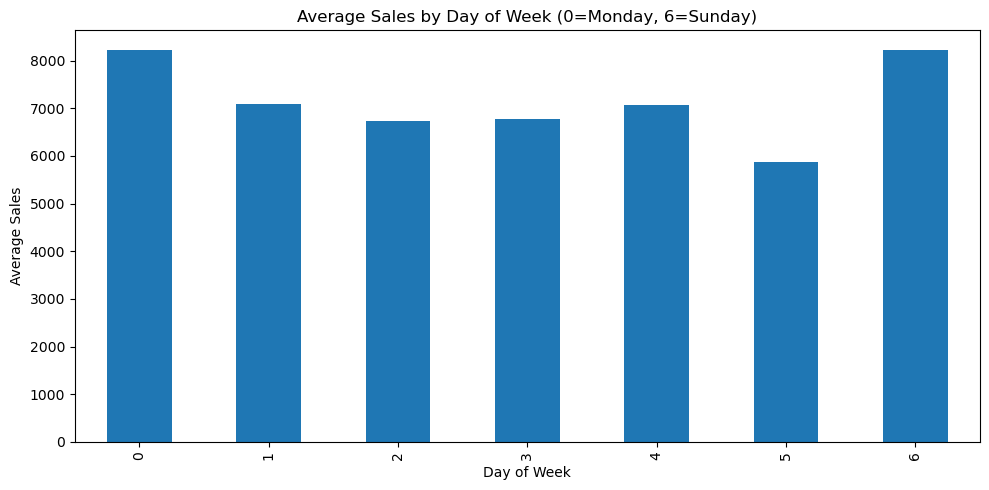


Promo Effect:
Promo
0    5929.826183
1    8228.739731
Name: Sales, dtype: float64
Sales lift with Promo: 38.77%


In [62]:
# Overall sales trend
daily_sales = df_open.groupby('Date')['Sales'].sum().reset_index()

plt.figure(figsize=(15, 5))
plt.plot(daily_sales['Date'], daily_sales['Sales'])
plt.title('Daily Total Sales Across All Stores')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Sales by Store Type
plt.figure(figsize=(10, 5))
df_open.groupby('StoreType')['Sales'].mean().plot(kind='bar')
plt.title('Average Sales by Store Type')
plt.xlabel('Store Type')
plt.ylabel('Average Sales')
plt.tight_layout()
plt.show()

# Sales by Day of Week
plt.figure(figsize=(10, 5))
df_open.groupby('DayOfWeek')['Sales'].mean().plot(kind='bar')
plt.title('Average Sales by Day of Week (0=Monday, 6=Sunday)')
plt.xlabel('Day of Week')
plt.ylabel('Average Sales')
plt.tight_layout()
plt.show()

# Promo effect
promo_effect = df_open.groupby('Promo')['Sales'].mean()
print("\nPromo Effect:")
print(promo_effect)
print(f"Sales lift with Promo: {((promo_effect[1] / promo_effect[0]) - 1) * 100:.2f}%")

#### Step 6: Prophet Forecasting (Aggregate All Stores)


Train period: 2013-01-01 00:00:00 to 2015-06-19 00:00:00
Test period: 2015-06-20 00:00:00 to 2015-07-31 00:00:00

Training Prophet model...


09:03:48 - cmdstanpy - INFO - Chain [1] start processing
09:03:49 - cmdstanpy - INFO - Chain [1] done processing


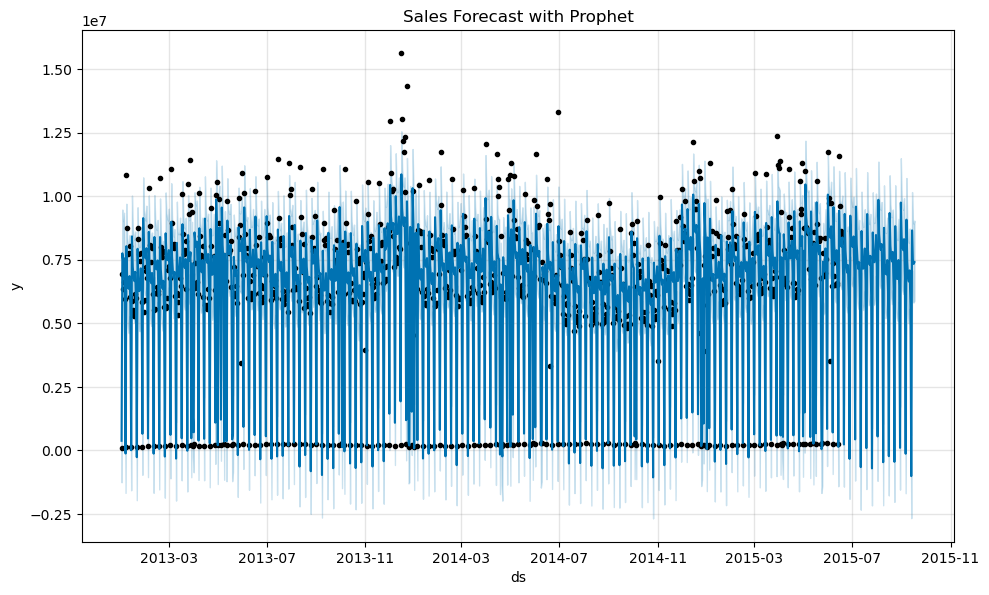

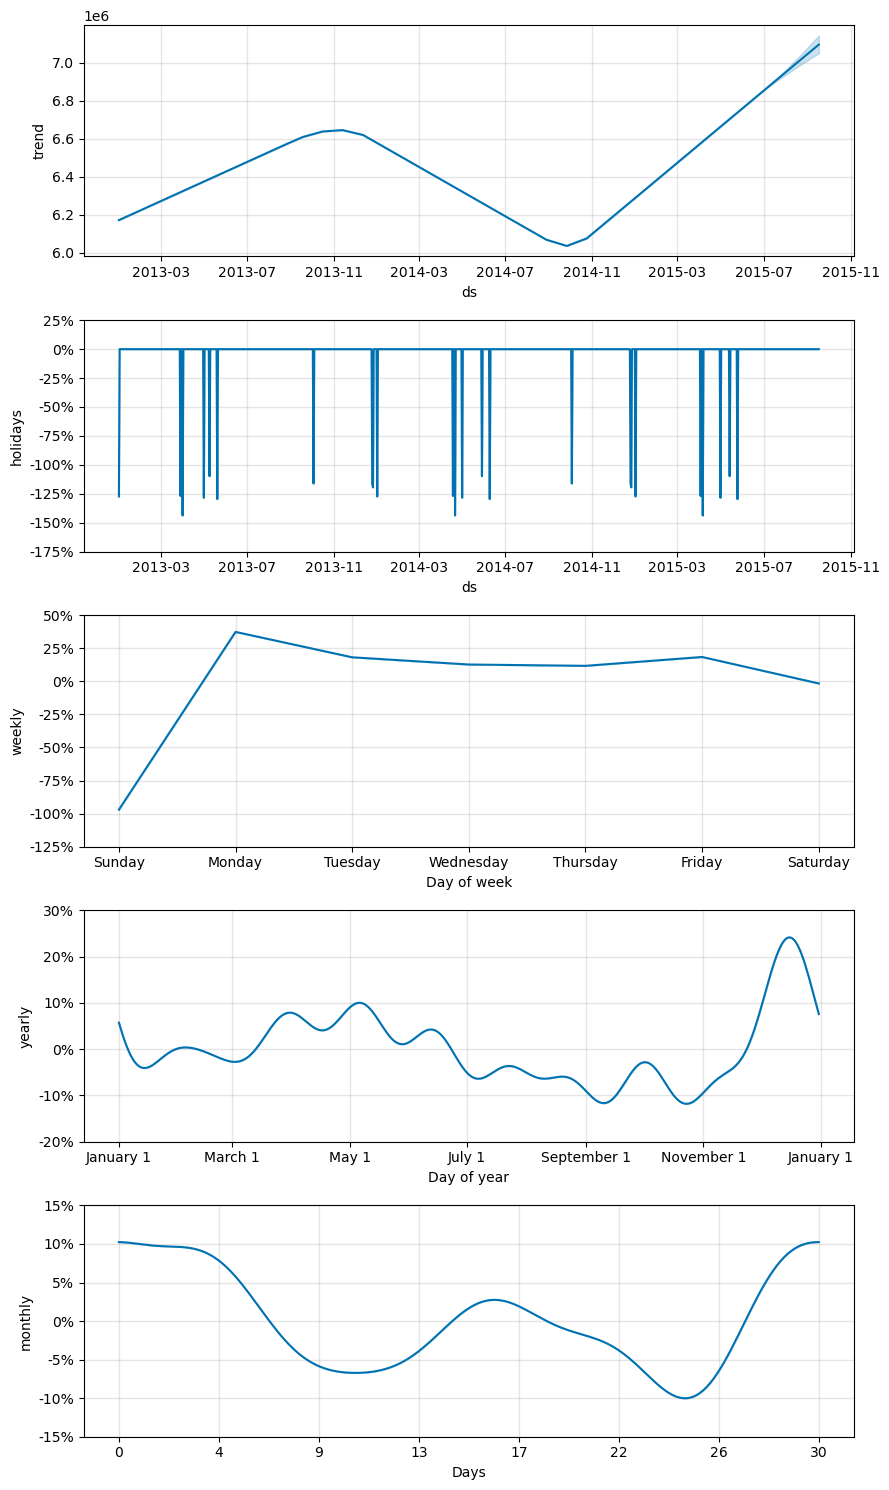

In [63]:
# Prepare data for Prophet - aggregate all stores
prophet_df = df_open.groupby('Date').agg({
    'Sales': 'sum',
    'Customers': 'sum',
    'Promo': 'mean'  # Average promo activity
}).reset_index()

prophet_df = prophet_df.rename(columns={'Date': 'ds', 'Sales': 'y'})

# Split into train and test (last 6 weeks for testing)
split_date = prophet_df['ds'].max() - pd.Timedelta(days=42)
train_prophet = prophet_df[prophet_df['ds'] <= split_date]
test_prophet = prophet_df[prophet_df['ds'] > split_date]

print(f"\nTrain period: {train_prophet['ds'].min()} to {train_prophet['ds'].max()}")
print(f"Test period: {test_prophet['ds'].min()} to {test_prophet['ds'].max()}")

# Initialize Prophet model
model = Prophet(
    yearly_seasonality=True,
    weekly_seasonality=True,
    daily_seasonality=False,
    changepoint_prior_scale=0.05,
    seasonality_mode='multiplicative'  # Better for retail data
)

# Add custom seasonality
model.add_seasonality(name='monthly', period=30.5, fourier_order=5)

# Add country holidays (adjust based on store locations)
model.add_country_holidays(country_name='DE')  # Germany for Rossmann

# Fit the model
print("\nTraining Prophet model...")
model.fit(train_prophet)

# Make predictions
future = model.make_future_dataframe(periods=90)  # Forecast 90 days ahead
forecast = model.predict(future)

# Visualize
fig1 = model.plot(forecast)
plt.title('Sales Forecast with Prophet')
plt.show()

fig2 = model.plot_components(forecast)
plt.show()

##### Step 7: Model Evaluation


MODEL PERFORMANCE METRICS
Mean Absolute Error (MAE): $1,086,269.45
Root Mean Squared Error (RMSE): $1,352,415.53
Mean Absolute Percentage Error (MAPE): 37.81%


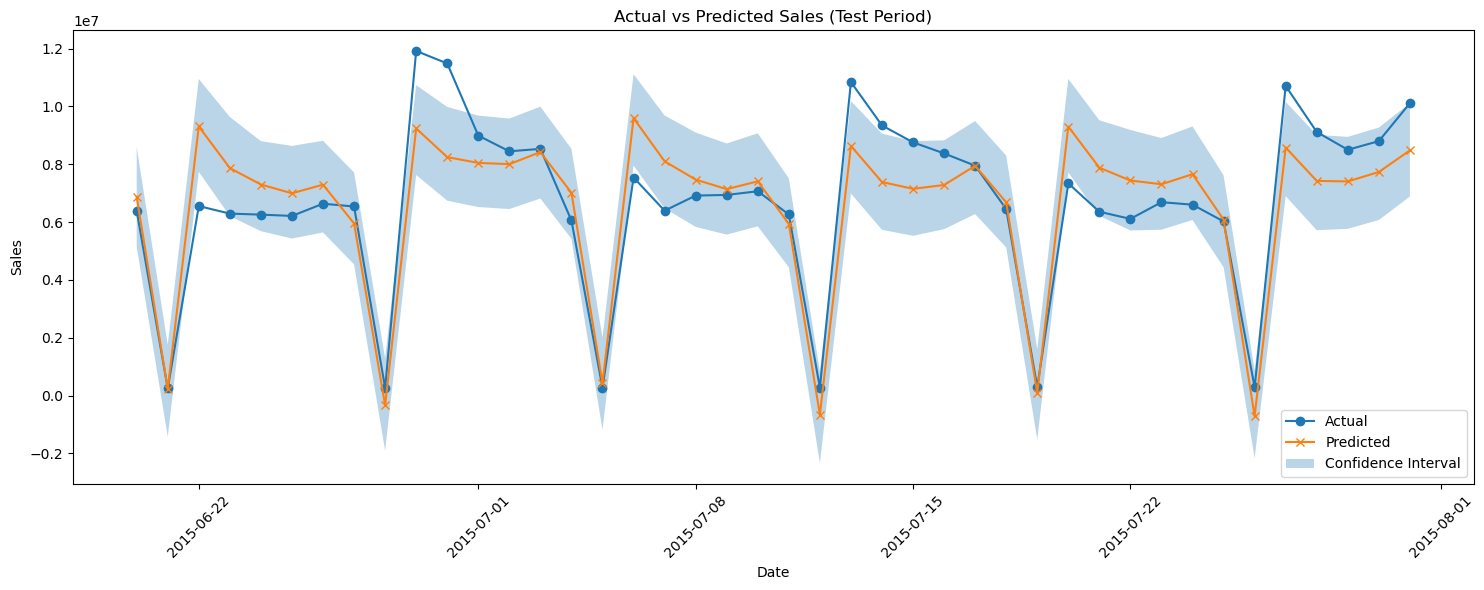

In [64]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Merge forecast with test data
test_results = test_prophet.merge(
    forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']], 
    on='ds', 
    how='left'
)

# Calculate metrics
mae = mean_absolute_error(test_results['y'], test_results['yhat'])
rmse = np.sqrt(mean_squared_error(test_results['y'], test_results['yhat']))
mape = np.mean(np.abs((test_results['y'] - test_results['yhat']) / test_results['y'])) * 100

print("\n" + "="*50)
print("MODEL PERFORMANCE METRICS")
print("="*50)
print(f"Mean Absolute Error (MAE): ${mae:,.2f}")
print(f"Root Mean Squared Error (RMSE): ${rmse:,.2f}")
print(f"Mean Absolute Percentage Error (MAPE): {mape:.2f}%")
print("="*50)

# Visualize predictions vs actual
plt.figure(figsize=(15, 6))
plt.plot(test_results['ds'], test_results['y'], label='Actual', marker='o')
plt.plot(test_results['ds'], test_results['yhat'], label='Predicted', marker='x')
plt.fill_between(test_results['ds'], 
                 test_results['yhat_lower'], 
                 test_results['yhat_upper'], 
                 alpha=0.3, label='Confidence Interval')
plt.title('Actual vs Predicted Sales (Test Period)')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

#### Step 8: Prepare Data for Power BI

In [66]:
# Create comprehensive output for Power BI
powerbi_output = forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].copy()
powerbi_output = powerbi_output.rename(columns={
    'ds': 'Date',
    'yhat': 'Forecasted_Sales',
    'yhat_lower': 'Lower_Bound',
    'yhat_upper': 'Upper_Bound'
})

# Add actual sales
actual_sales = prophet_df[['ds', 'y']].rename(columns={'ds': 'Date', 'y': 'Actual_Sales'})
powerbi_output = powerbi_output.merge(actual_sales, on='Date', how='left')

# Add flag for historical vs forecast
powerbi_output['Type'] = powerbi_output['Actual_Sales'].apply(
    lambda x: 'Historical' if pd.notna(x) else 'Forecast'
)

# Export
powerbi_output.to_csv('rossmann_sales_forecast.csv', index=False)
print("\n Forecast exported to 'rossmann_sales_forecast.csv'")

# Also export store-level summary for dashboard
store_summary = df_open.groupby('Store').agg({
    'Sales': ['sum', 'mean'],
    'Customers': 'sum',
    'StoreType': 'first',
    'Assortment': 'first'
}).reset_index()
store_summary.columns = ['Store', 'Total_Sales', 'Avg_Daily_Sales', 
                         'Total_Customers', 'StoreType', 'Assortment']
store_summary.to_csv('store_performance.csv', index=False)
print(" Store summary exported to 'store_performance.csv'")


 Forecast exported to 'rossmann_sales_forecast.csv'
 Store summary exported to 'store_performance.csv'
